# Covid Vaccine Study

Data: 
- 5' GEX, VDJ, Antibody Capture, and CiteSeq data in various combination

In [1]:
%load_ext autoreload

In [2]:
%matplotlib inline

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

import os

import scanpy as sc
import scirpy as ir
import anndata as ann

import numpy as np
import pandas as pd
import seaborn as sb
import matplotlib.pyplot as plt

from matplotlib import rcParams

C:\Users\felix.drost\Anaconda3\envs\covidVac\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
%autoreload 2
import sys
sys.path.append('..')

import utils.annotation as utils_annotation
import utils.representation as utils_representation
import utils.visualisation as utils_vis

In [4]:
sc.settings.set_figure_params(dpi=150)
sc.settings.verbosity = 3
sc.set_figure_params(vector_friendly=True, color_map='viridis', transparent=True)
sb.set_style('whitegrid')
#sb.set(rc={'axes.facecolor':'white', 'figure.facecolor':'white'})

## Settings

In [5]:
path_base = '../../data/20231017'
path_merged = f'{path_base}/01_mixed_merged_3.h5ad'

## Sample 3
- Donor A8 d10 1° (HA1)
    + Dextramers: LTD, QPY, TFE
    + Cite: CD62L, CCR7, CD45RA, CXCR3
- Donor A8 d10 2° (HA2)
    + Dextramers: LTD, QPY, TFE
    + Cite: CD62L, CCR7, CD45RA, CXCR3
- Donor A8 d210 2° (HA3)
    + Dextramers: LTD, QPY, TFE
    + Cite: CD62L, CCR7, CD45RA, CXCR3
- Donor A8 d10 3° (HA4)
    + Dextramers: LTD, QPY, TFE
    + Cite: CD62L, CCR7, CD45RA, CXCR3
- Donor A8 d108 3° (HA5)
    + Dextramers: LTD, QPY, TFE
    + Cite: CD62L, CCR7, CD45RA, CXCR3
- Donor A8 d189 3° (HA6)
    + Dextramers: LTD, QPY, TFE
    + Cite: CD62L, CCR7, CD45RA, CXCR3
- Donor A5 d11 3° (HA7)
    + Dextramers: NYN, SPR, FPQ, IYK, TFE
    + Cite: CD62L, CCR7, CD45RA, CXCR3

In [6]:
hashtags = [f'HA{i}' for i in range(1, 8)]

epitope_ids = ['LTDEMIAQY', 'QPYRVVVL', 'NYNYLYRLF', 'SPRRARSVA', 'FPQSAPHGV', 'IYKTPPIKDF', 'TFEYVSQPFLMDLE']

costum_cite = ['CD62L', 'CCR7', 'CD45RA', 'CXCR3']

feature_barcode_ids = hashtags + epitope_ids + costum_cite

In [7]:
sample = 3

# GEX data
path_gex = f'{path_base}/GEX/gex_mixed_run_{sample}_feature_bc_matrix.h5'
adata = sc.read_10x_h5(path_gex, gex_only=False)
adata.var_names_make_unique()

# VDJ data
path_vdj = f'{path_base}/VDJ/vdj_mixed_runs_{sample}_filtered_contig.csv'
adata_vdj = ir.io.read_10x_vdj(path_vdj)
ir.pp.merge_with_ir(adata, adata_vdj)


# Epitope data
adata.uns['epitopes'] = epitope_ids
for e in epitope_ids:
    adata.obs[e] = adata[:, e].X.A.copy()

# Hashtag data
adata.uns['hashtags'] = hashtags
for h in hashtags:
    adata.obs[h] = adata[:, h].X.A.copy()

# CiteSeq Data
adata.uns['cite_ids'] = costum_cite
for c in costum_cite:
    adata.obs[c] = adata[:, c].X.A.copy()
    
# Remove Barcodes from counts
adata = adata[:, [gene for gene in adata.var_names if gene not in feature_barcode_ids]]
adata.obs['sample'] = f'202310_{sample}'

adata.shape

reading ../../data/20231017/GEX/gex_mixed_run_3_feature_bc_matrix.h5
 (0:00:00)


C:\Users\felix.drost\Anaconda3\envs\covidVac\lib\site-packages\anndata\_core\anndata.py:1830: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")
C:\Users\felix.drost\Anaconda3\envs\covidVac\lib\site-packages\ipykernel_launcher.py:31: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.


(11408, 36601)

In [8]:
len([el for el in adata.obs.index if el not in adata_vdj.obs.index])

6909

## Quality Control

Basic analysis by amount counts, genes, and fraction of mitochondrial genes

In [9]:
adata.obs['n_counts'] = adata.X.A.sum(axis=1)
adata.obs['log_counts'] = np.log10(adata.obs['n_counts'])
adata.obs['n_genes'] = (adata.X.A > 0).sum(axis=1)
adata.obs['log_genes'] = np.log10(adata.obs['n_genes'])

mt_gene_mask = [gene.startswith('MT-') for gene in adata.var_names]
mt_gene_idx = np.where(mt_gene_mask)[0]
adata.obs['mt_frac'] = adata.X.A[:, mt_gene_idx].sum(1) / adata.X.A.sum(axis=1)

In [10]:
print('Mean # Genes: ', adata.obs['n_genes'].mean())
print('Median # Genes: ', adata.obs['n_genes'].median())
print('Mean # Counts: ', adata.obs['n_counts'].mean())
print('Median # Counts: ', adata.obs['n_counts'].median())
print('Mean % MT: ', adata.obs['mt_frac'].mean())
print('Median % MT: ', adata.obs['mt_frac'].median())

Mean # Genes:  901.234572230014
Median # Genes:  608.0
Mean # Counts:  2261.231689453125
Median # Counts:  1528.0
Mean % MT:  0.025782471522688866
Median % MT:  0.0163362305611372


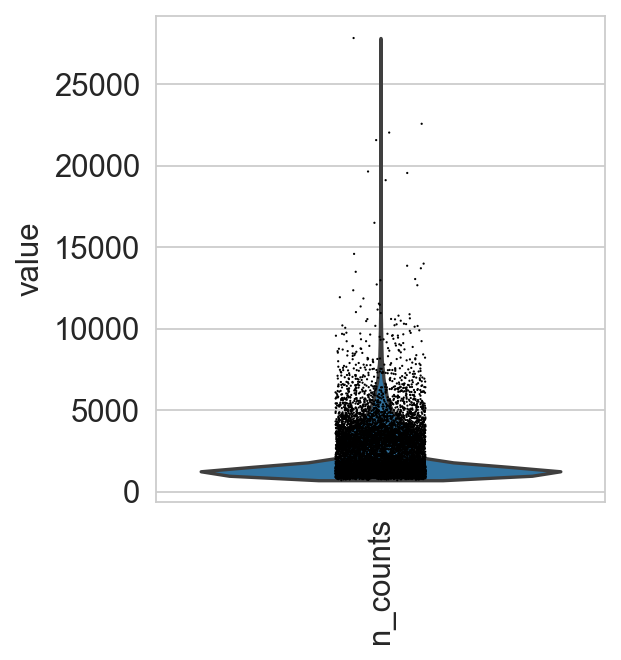

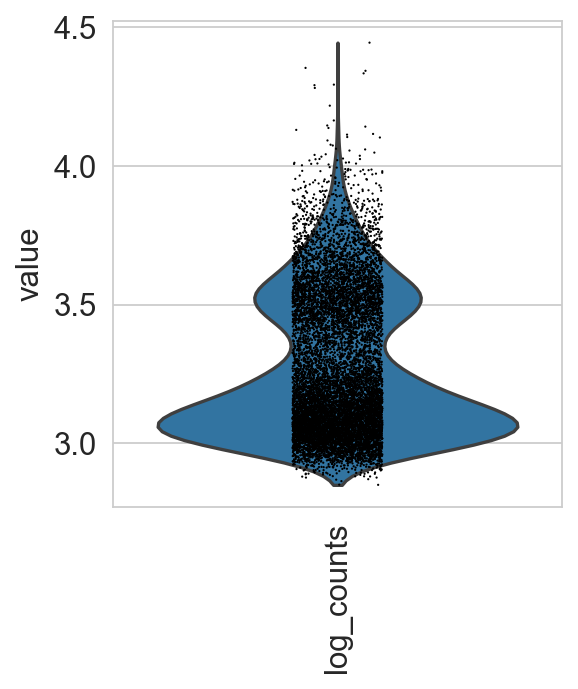

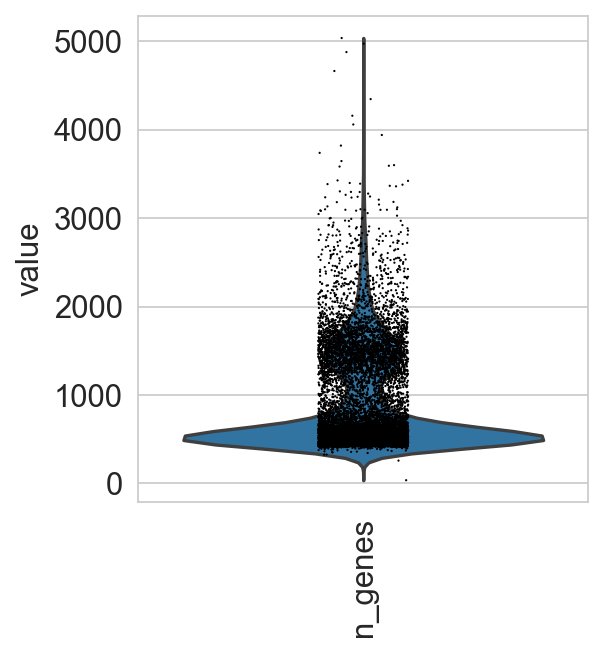

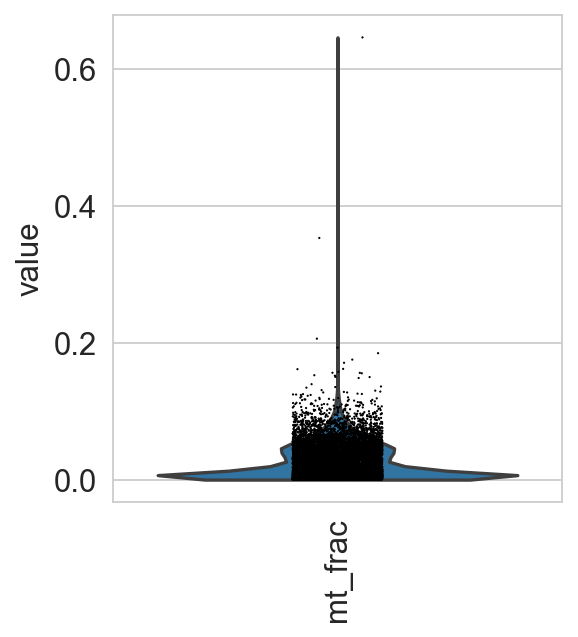

In [11]:
rcParams['figure.figsize'] = (4, 4)
sc.pl.violin(adata, ['n_counts'], size=1, log=False, rotation=90)
sc.pl.violin(adata, ['log_counts'], size=1, log=False, rotation=90)
sc.pl.violin(adata, ['n_genes'], size=1, log=False, rotation=90)
sc.pl.violin(adata, ['mt_frac'], size=1, log=False, rotation=90)

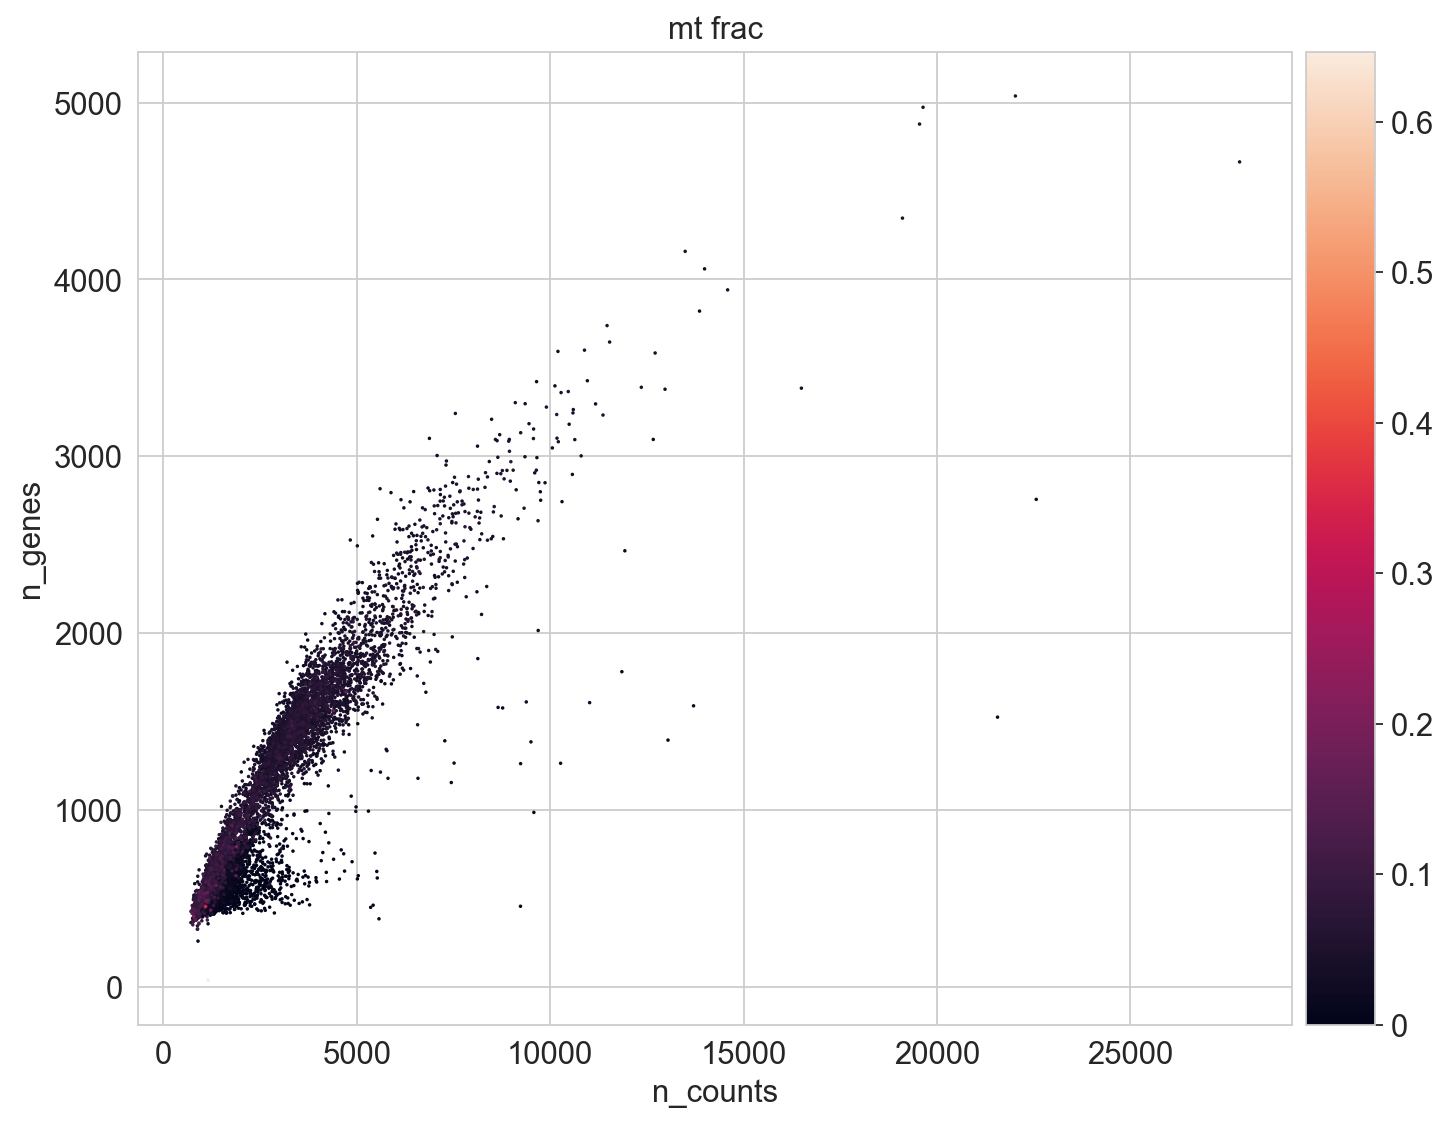

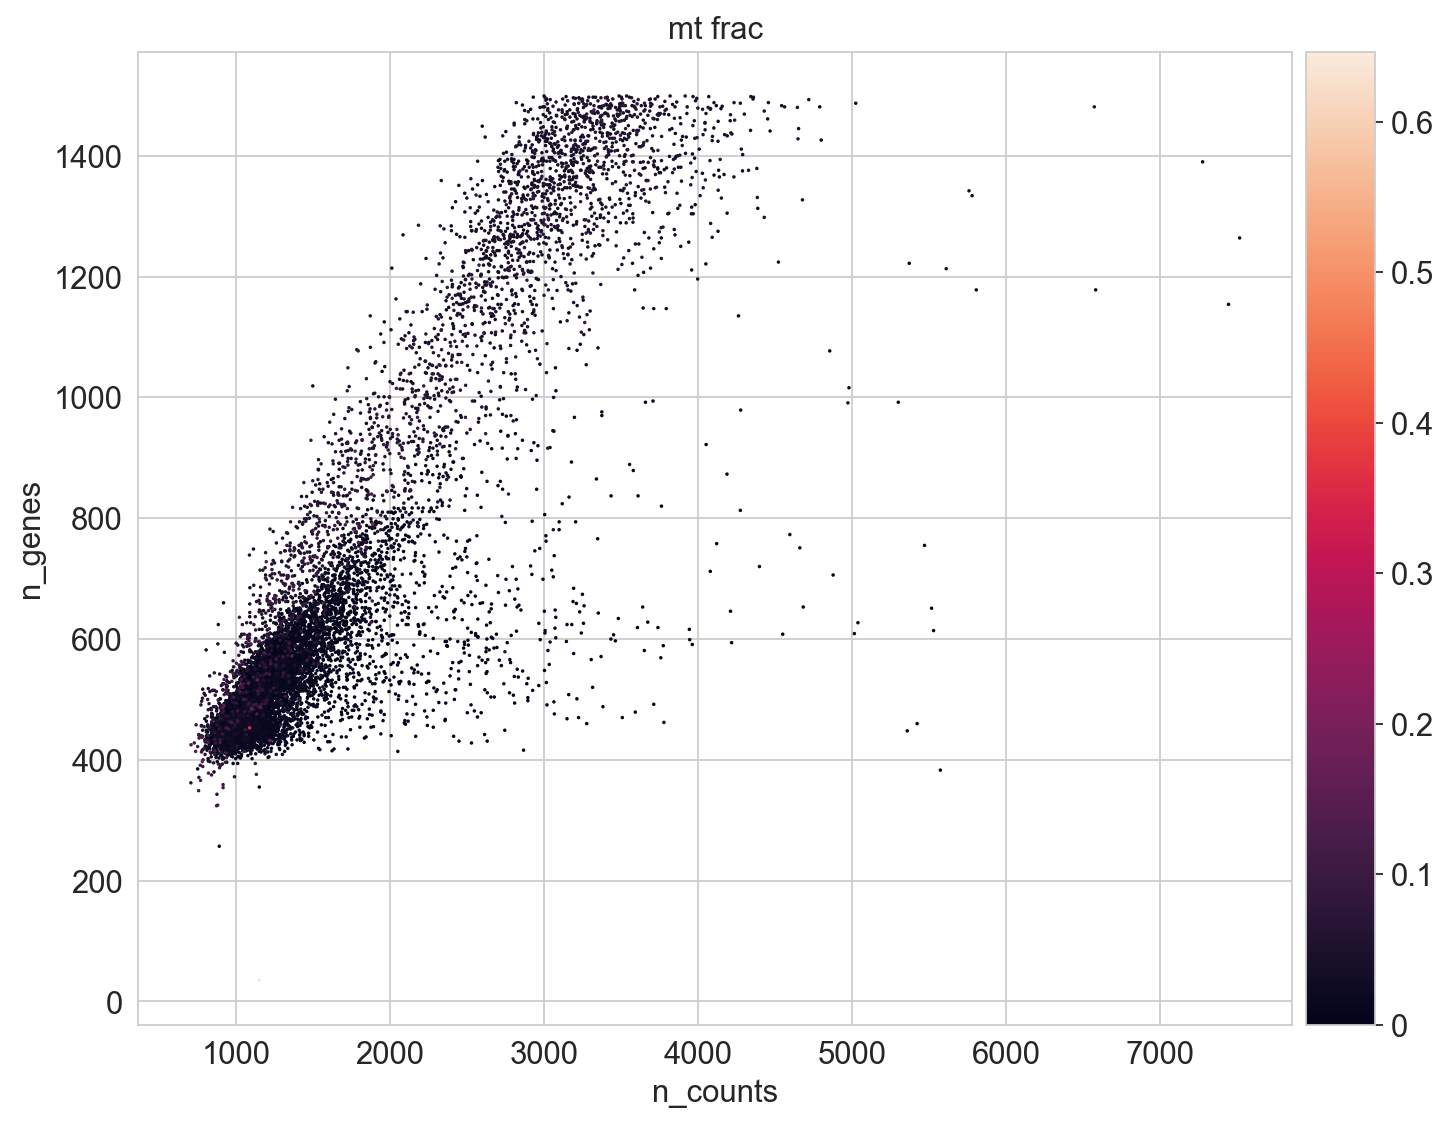

In [12]:
rcParams['figure.figsize'] = (8, 8)
sc.pl.scatter(adata, y='n_genes', x='n_counts', color ='mt_frac', size=10, show=False)
sc.pl.scatter(adata[np.logical_and(adata.obs['n_genes']<1500, adata.obs['n_counts']<8000)],
         y='n_genes', x='n_counts', color='mt_frac', size=10, show=False)
plt.show()

### Apply Filtering

In [13]:
params_filter = {   'mt_frac': 0.1,
    'n_counts_min': 2500,
    'n_counts_max': 6000,
    'n_genes_min': 1000,
}

In [14]:
print(f'Size before filtering: {len(adata)}')
adata = adata[adata.obs['mt_frac'] < params_filter['mt_frac']]
adata = adata[adata.obs['n_counts'] > params_filter['n_counts_min']]
adata = adata[adata.obs['n_counts'] < params_filter['n_counts_max']]
adata = adata[adata.obs['n_genes'] > params_filter['n_genes_min']].copy()
print(f'Size after filtering: {len(adata)}')
    
adata.shape

Size before filtering: 11408
Size after filtering: 3065


(3065, 36601)

## QC after filtering

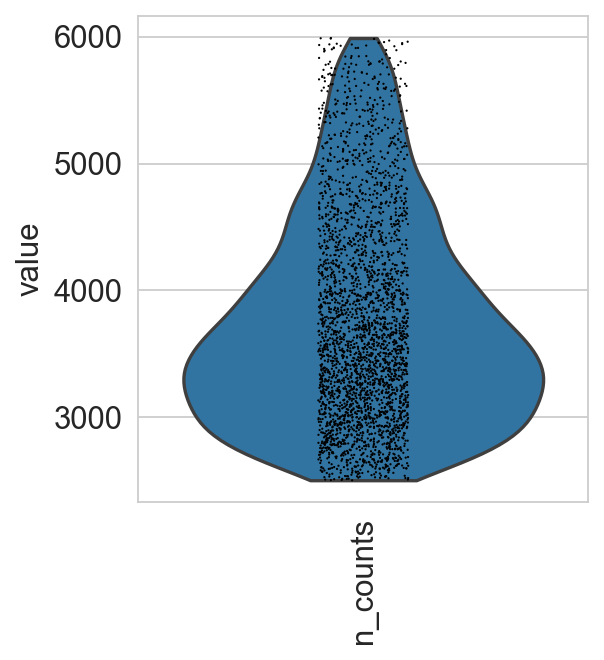

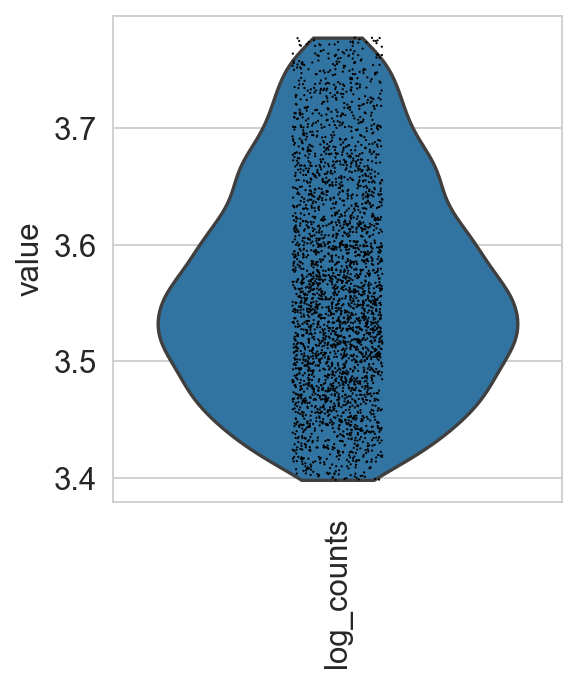

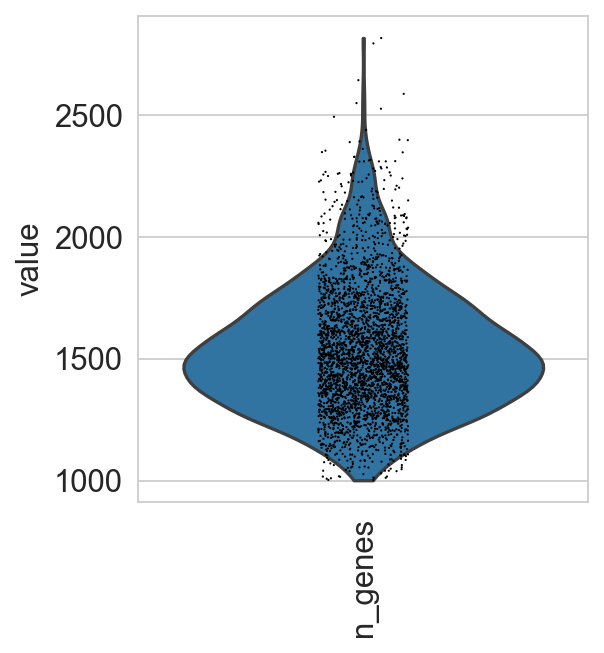

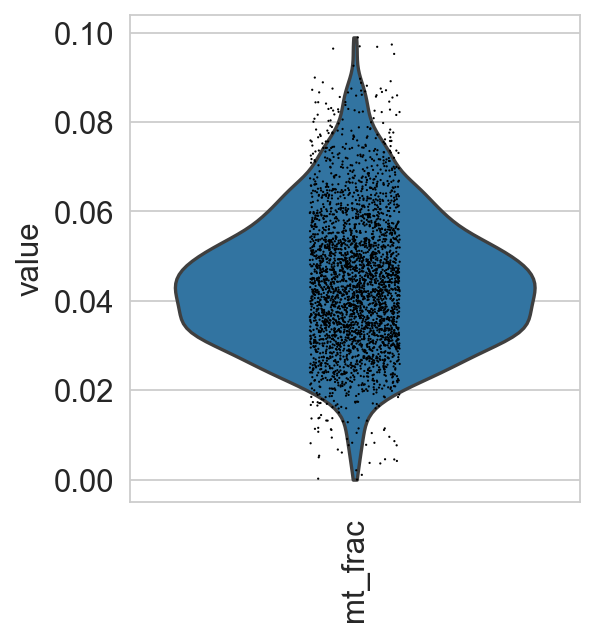

In [15]:
rcParams['figure.figsize'] = (4, 4)
sc.pl.violin(adata, ['n_counts'], size=1, log=False, rotation=90)
sc.pl.violin(adata, ['log_counts'], size=1, log=False, rotation=90)
sc.pl.violin(adata, ['n_genes'], size=1, log=False, rotation=90)
sc.pl.violin(adata, ['mt_frac'], size=1, log=False, rotation=90)

## TCR stats

In [16]:
ir.tl.chain_pairing(adata)
adata.obs['chain_pairing'].value_counts()

single pair        2124
orphan VDJ          366
no IR               338
extra VJ            134
extra VDJ            51
orphan VJ            43
two full chains       9
Name: chain_pairing, dtype: int64

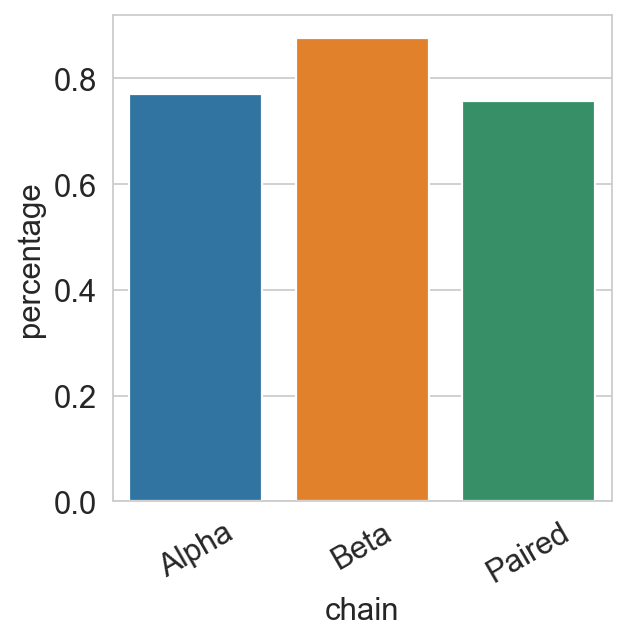

In [17]:
def get_percentages_tcr(data):
    p_alpha = data.obs['IR_VJ_1_junction_aa'].notnull().mean()
    p_beta = data.obs['IR_VDJ_1_junction_aa'].notnull().mean()
    p_paired = (data.obs['IR_VDJ_1_junction_aa'].notnull() & data.obs['IR_VJ_1_junction_aa'].notnull()).mean()
    return [p_alpha, p_beta, p_paired]

chains = ['Alpha', 'Beta', 'Paired']
percentages = get_percentages_tcr(adata)

df_tcr_fractions = {
    'chain': chains,
    'percentage': percentages
}

df_tcr_fractions = pd.DataFrame(df_tcr_fractions)
g = sb.barplot(data=df_tcr_fractions, y='percentage', x='chain')
_ = g.set_xticklabels(rotation=30, labels=g.get_xticklabels())

## Normalization

In [18]:
sc.pp.normalize_total(adata, target_sum=1e4)
sc.pp.log1p(adata)

normalizing counts per cell
    finished (0:00:00)


## Quick Visual Sanity Check

If you pass `n_top_genes`, all cutoffs are ignored.
extracting highly variable genes
    finished (0:00:00)
--> added
    'highly_variable', boolean vector (adata.var)
    'means', float vector (adata.var)
    'dispersions', float vector (adata.var)
    'dispersions_norm', float vector (adata.var)
computing neighbors
         Falling back to preprocessing with `sc.pp.pca` and default params.
computing PCA
    with n_comps=50


C:\Users\felix.drost\Anaconda3\envs\covidVac\lib\site-packages\anndata\compat\_overloaded_dict.py:106: ImplicitModificationWarning: Trying to modify attribute `._uns` of view, initializing view as actual.
  self.data[key] = value


    finished (0:00:02)
    finished: added to `.uns['neighbors']`
    `.obsp['distances']`, distances for each pair of neighbors
    `.obsp['connectivities']`, weighted adjacency matrix (0:00:10)
computing UMAP
    finished: added
    'X_umap', UMAP coordinates (adata.obsm) (0:00:07)


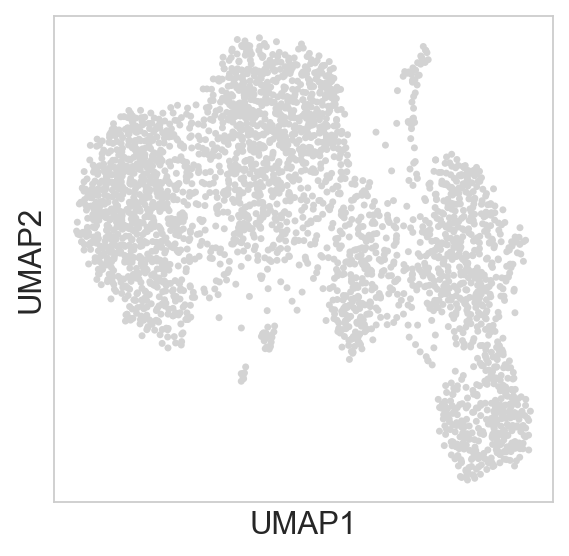

In [19]:
utils_representation.calculate_umap(adata, n_high_var=5000, remove_tcr_genes=True)
sc.pl.umap(adata)

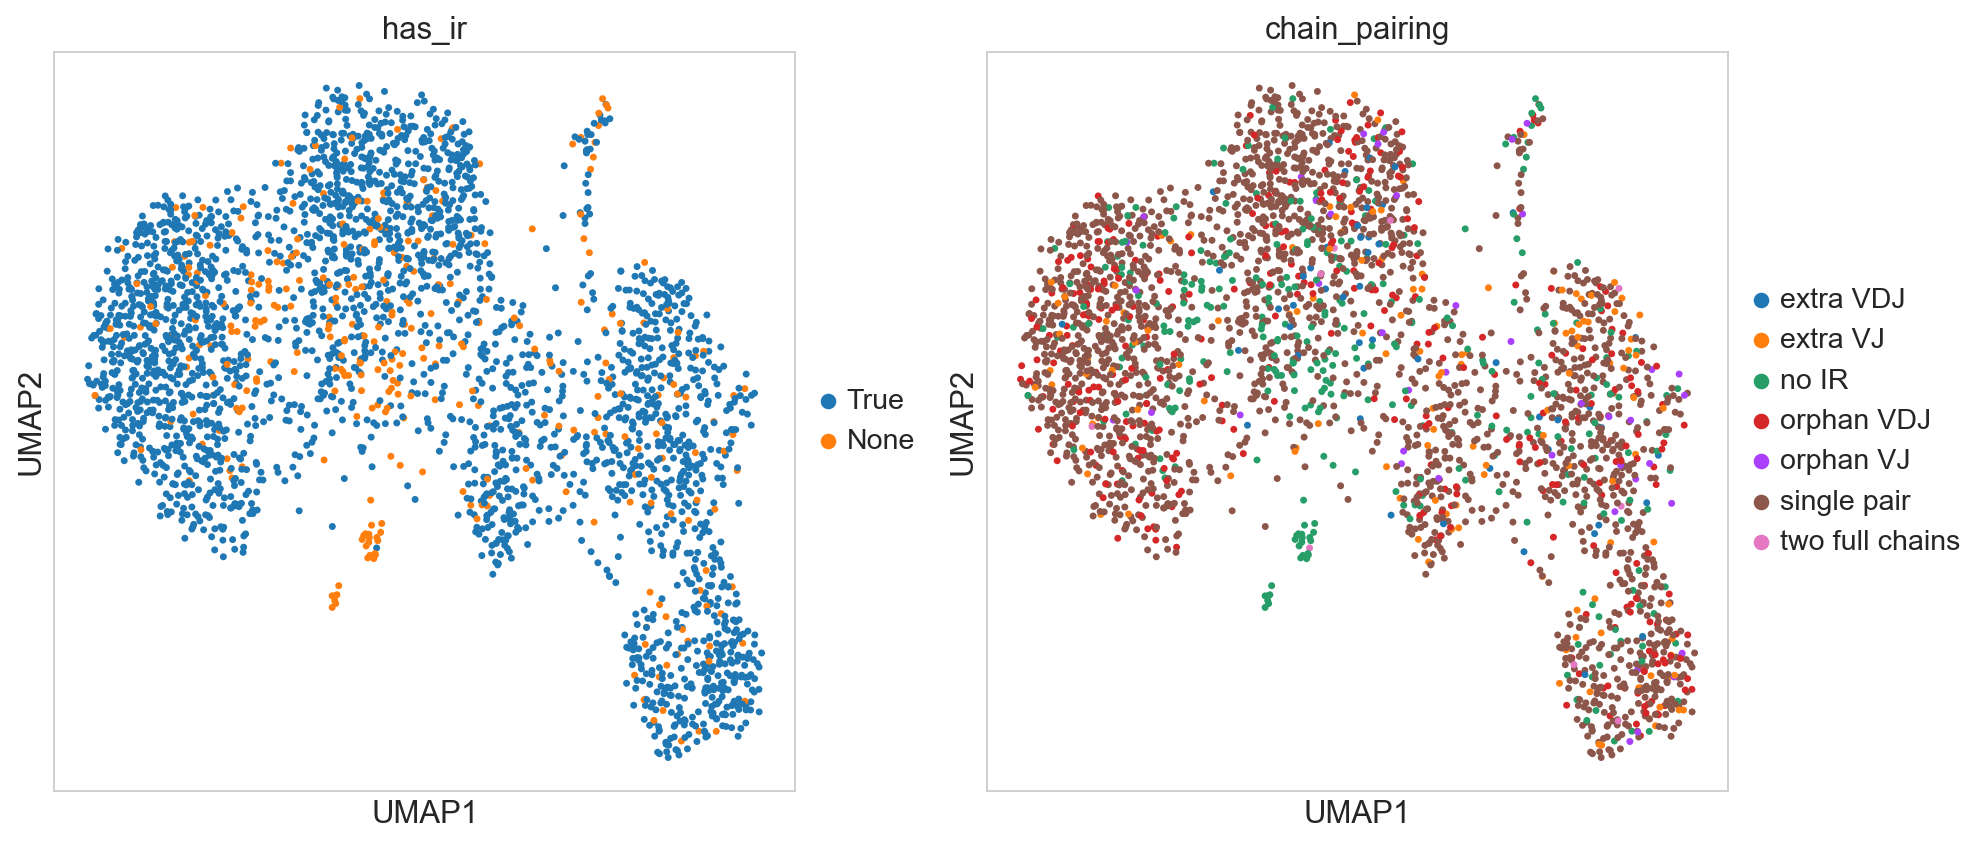

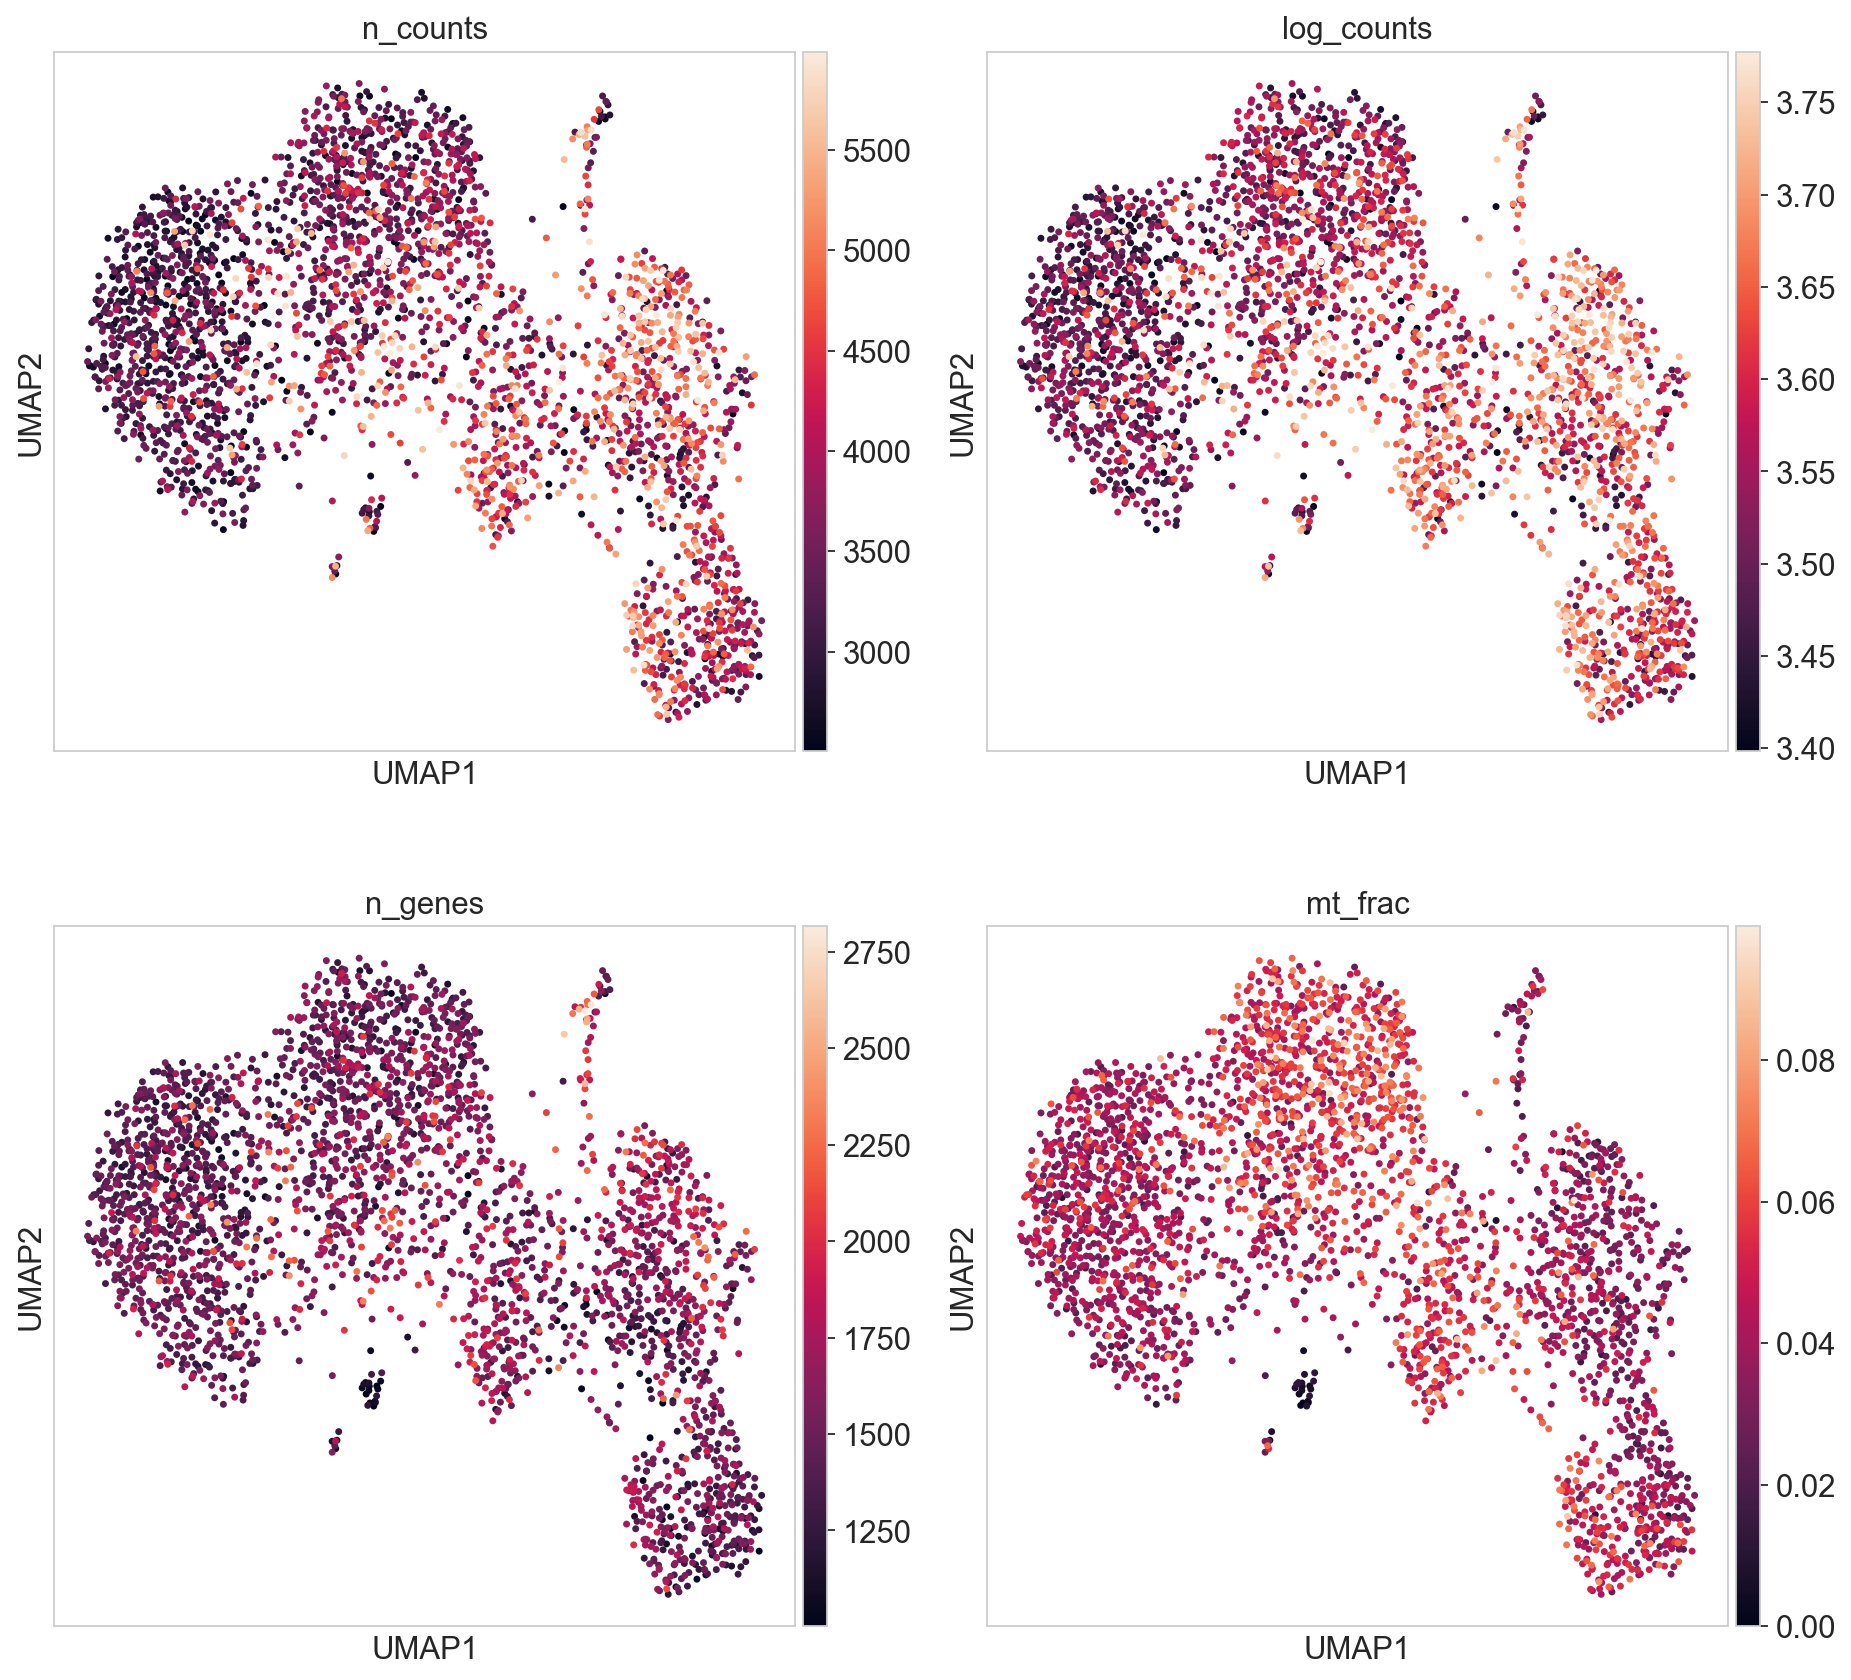

In [20]:
rcParams['figure.figsize'] = (6, 6)
sc.pl.umap(adata, color=['has_ir', 'chain_pairing'])
sc.pl.umap(adata, color=['n_counts', 'log_counts', 'n_genes', 'mt_frac'], ncols=2)

## Separate Donors

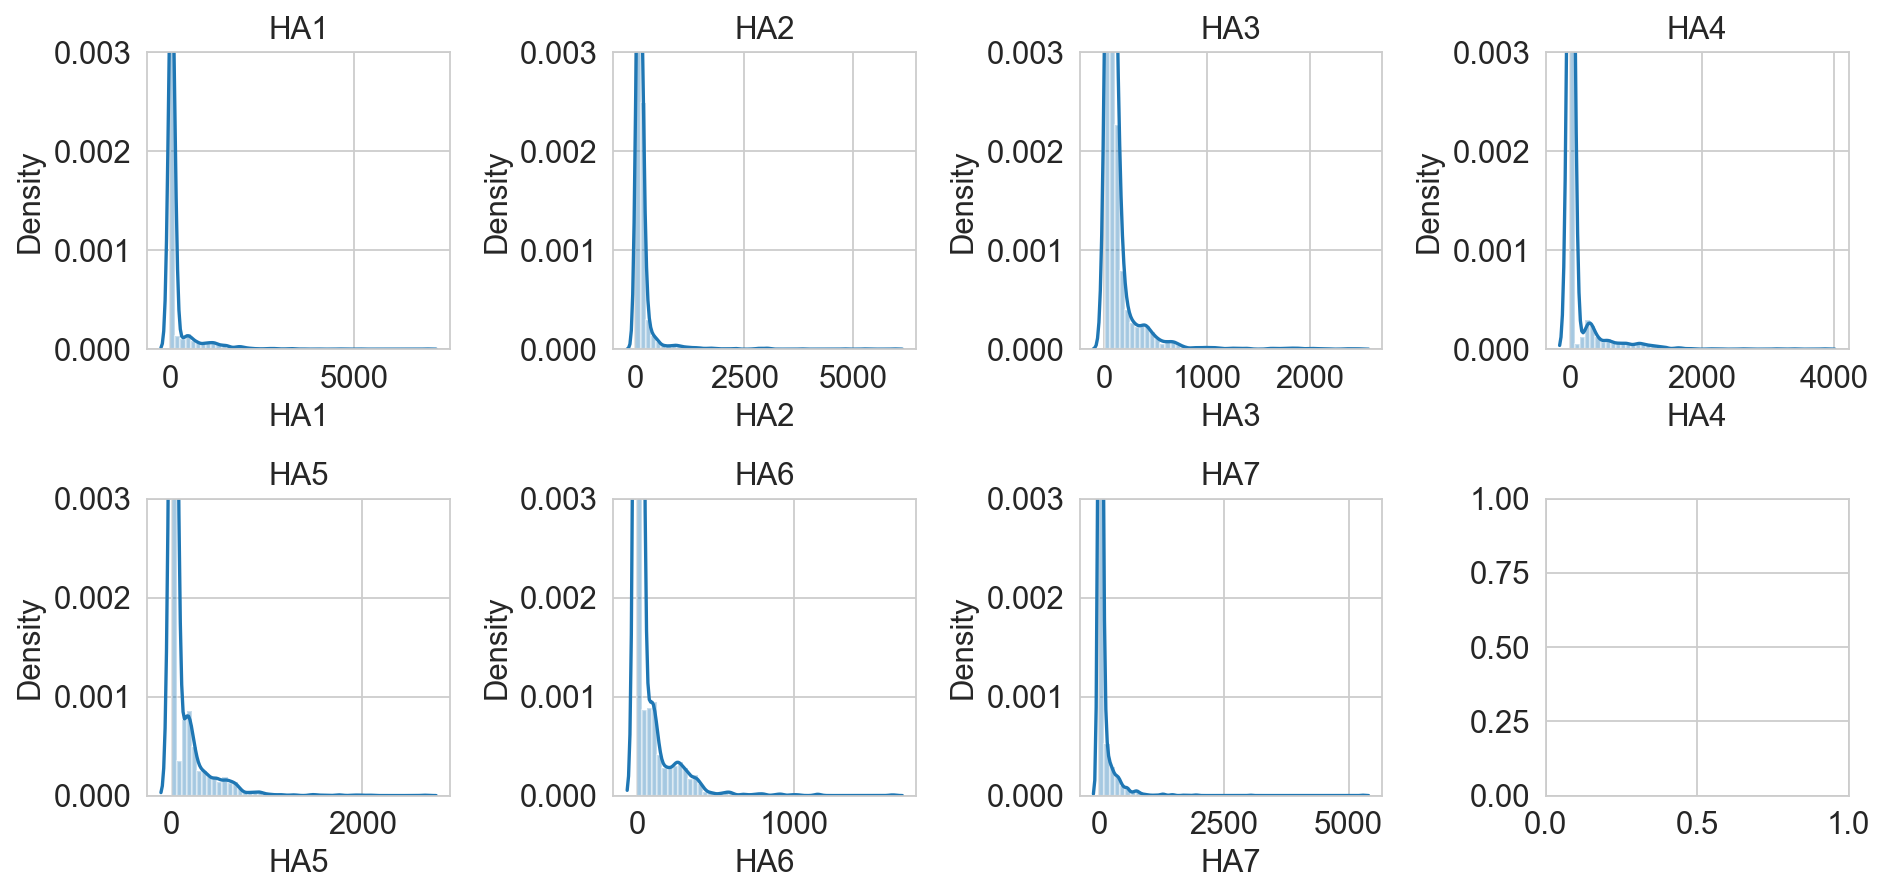

In [21]:
utils_vis.distributions_over_columns(adata, hashtags, 2, 4)

In [22]:
def hash_solo_by_sample(hashtag_cols, col_name, n_noise_barcodes):
    adata.obs[col_name] = 'NaN'

    dfs_donor = []
    adata.obs = adata.obs.drop(col_name, axis=1)
    sc.external.pp.hashsolo(adata, hashtag_cols, number_of_noise_barcodes=n_noise_barcodes)
    adata.obs = adata.obs.rename(columns={'Classification': col_name})

hash_solo_by_sample(hashtags, 'pool', 3)
adata.obs['pool'].value_counts()

Please cite HashSolo paper:
https://www.cell.com/cell-systems/fulltext/S2405-4712(20)30195-2


Doublet     1175
HA5          357
HA3          338
HA2          301
HA7          265
HA6          215
HA4          210
HA1          203
Negative       1
Name: pool, dtype: int64

In [23]:
hash_solo_by_sample(hashtags, 'pool', 5)
adata.obs['pool'].value_counts()

Please cite HashSolo paper:
https://www.cell.com/cell-systems/fulltext/S2405-4712(20)30195-2


HA5         562
HA3         500
HA7         410
HA6         349
Doublet     313
HA4         313
HA1         311
HA2         305
Negative      2
Name: pool, dtype: int64

<AxesSubplot:>

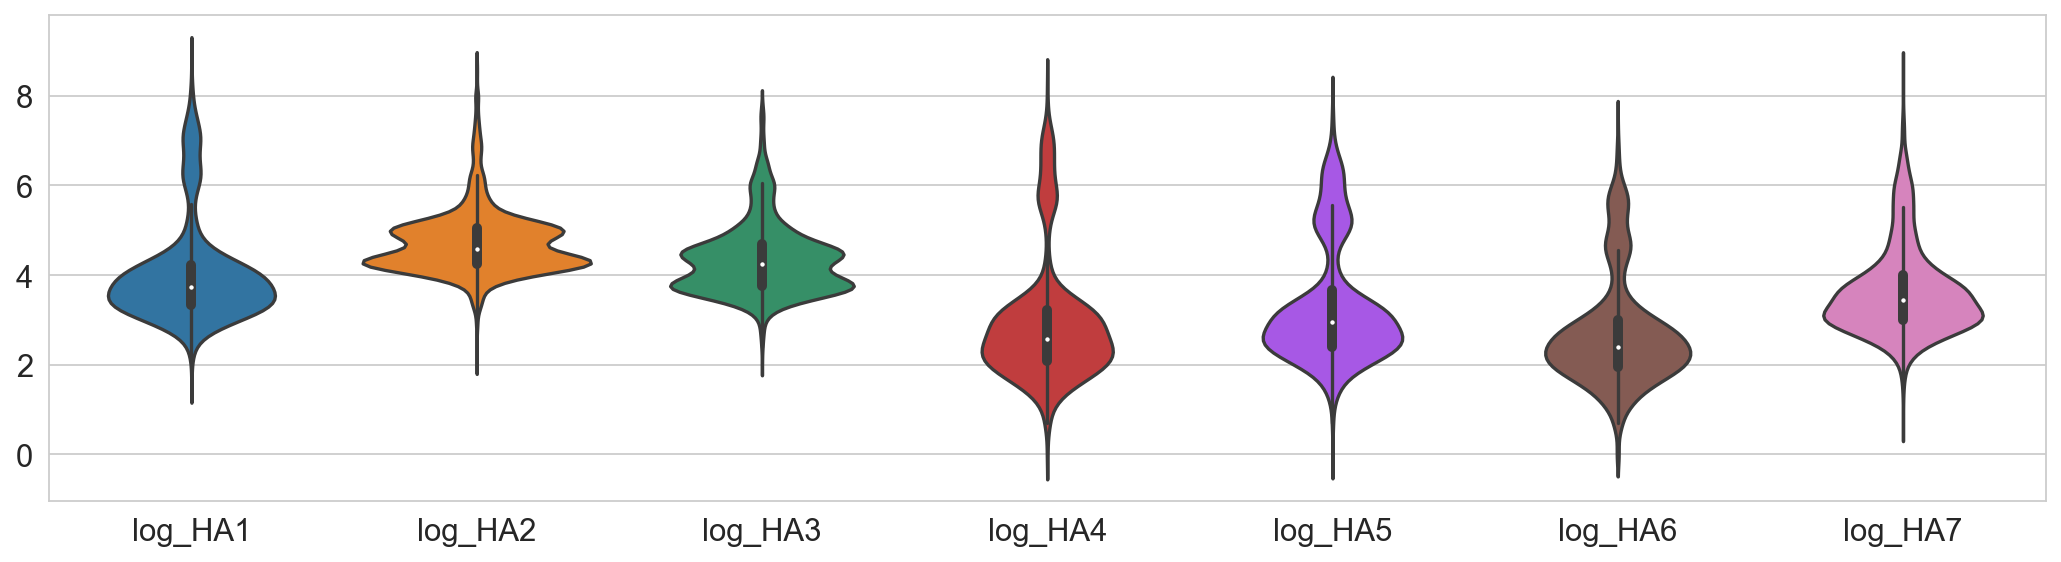

In [24]:
rcParams['figure.figsize'] = (16, 4)

for h in hashtags:
    adata.obs[f'log_{h}'] = np.log(adata.obs[h].values+1)
sb.violinplot(data=adata.obs[[f'log_{h}' for h in hashtags]], scale='area')

..\utils\visualisation.py:108: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


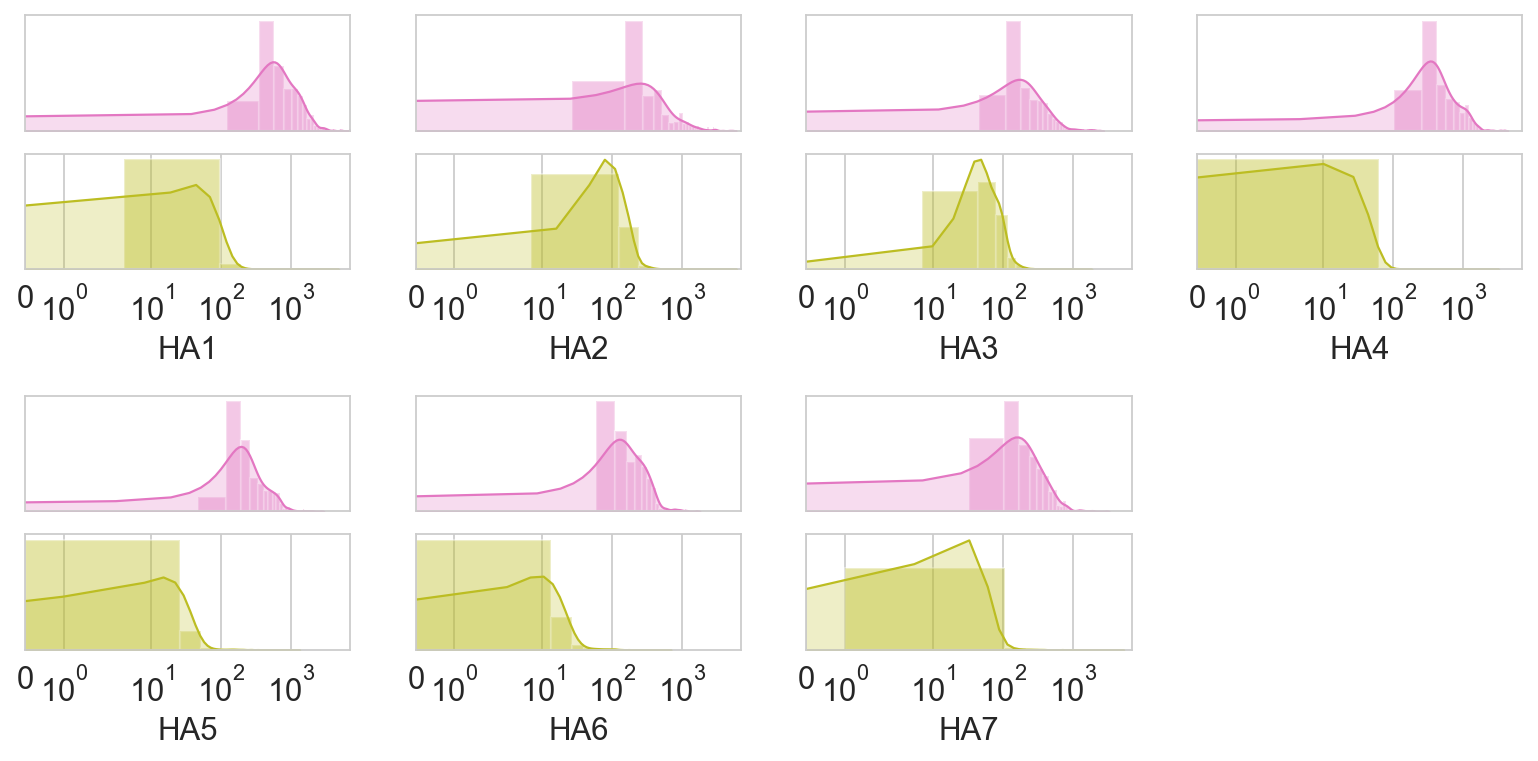

In [25]:
utils_vis.adt_counts_by_condition(adata, hashtags, 'pool', 8, 4, do_log=True)

computing neighbors
    using data matrix X directly
    finished: added to `.uns['neighbors']`
    `.obsp['distances']`, distances for each pair of neighbors
    `.obsp['connectivities']`, weighted adjacency matrix (0:00:00)
computing UMAP
    finished: added
    'X_umap', UMAP coordinates (adata.obsm) (0:00:06)


FileNotFoundError: [Errno 2] No such file or directory: 'figures\\umap\\..\\..\\..\\..\\figures\\mixed_run\\sample_3_hashtag_umap.pdf'

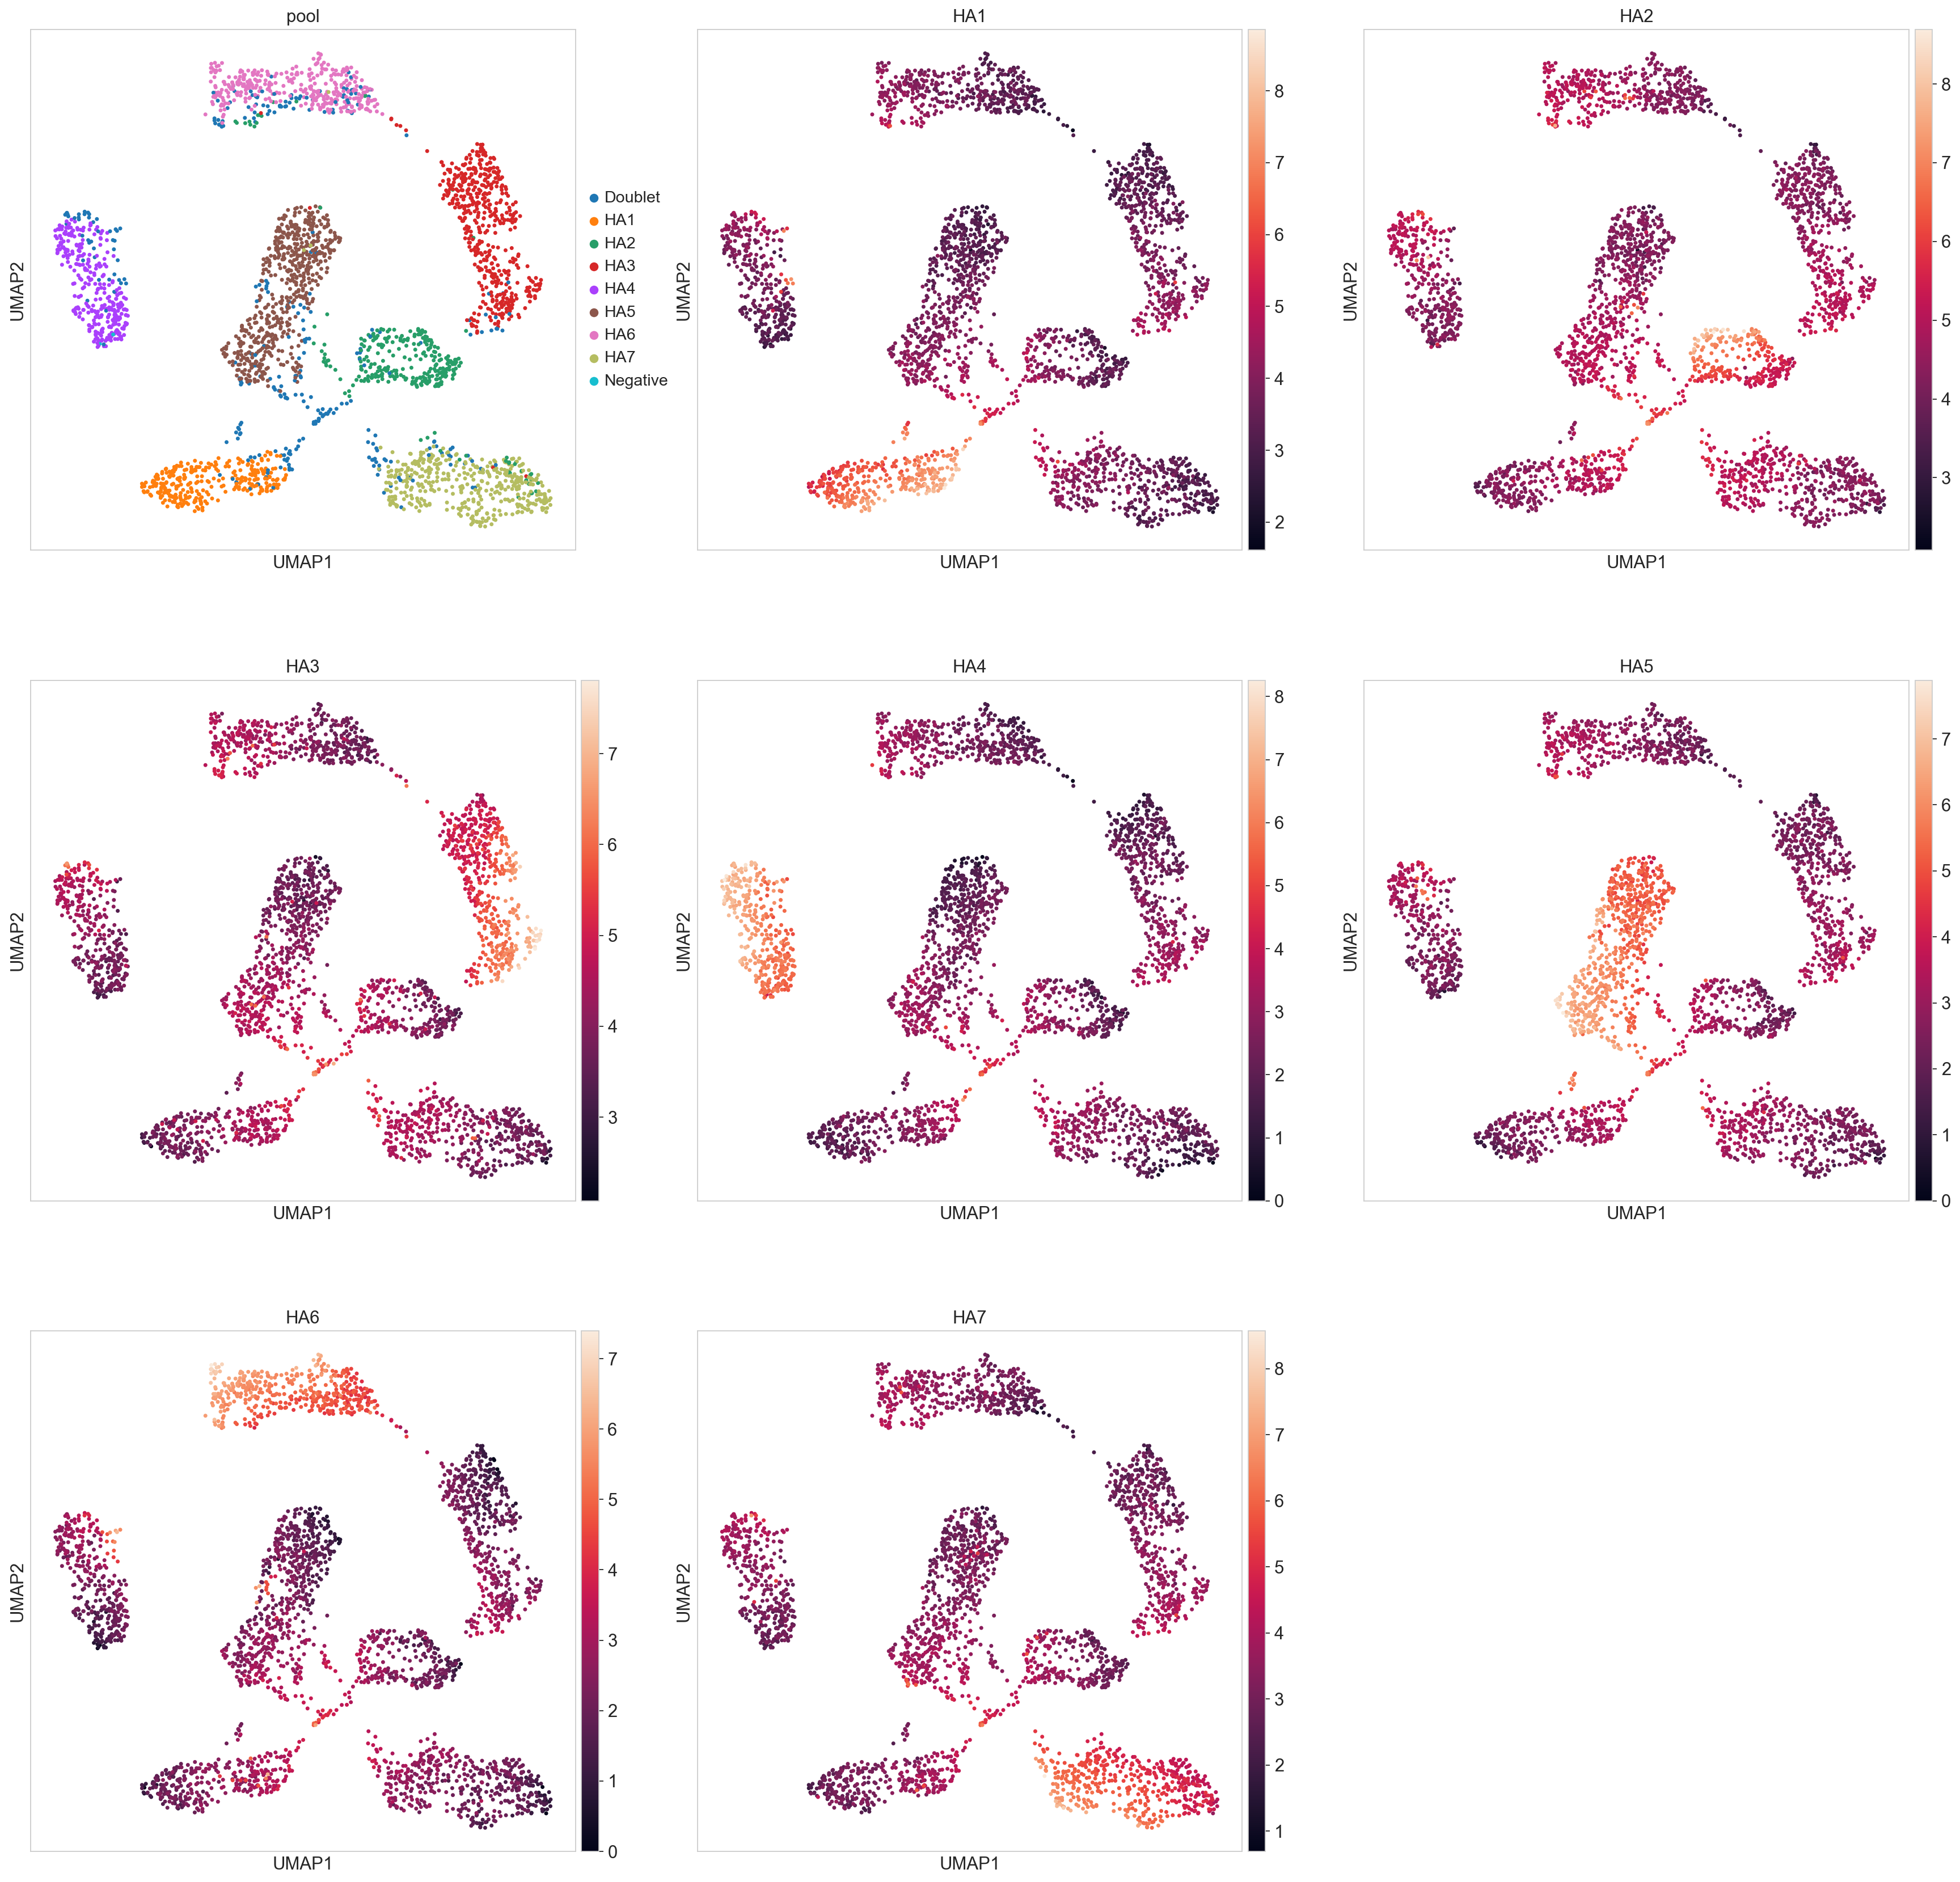

In [26]:
rcParams['figure.figsize'] = (8, 8)
adata_ha = ann.AnnData(X=adata.obs[adata.uns['hashtags']], obs=adata.obs[['pool']])
adata_ha.var_names = adata.uns['hashtags']
sc.pp.log1p(adata_ha)
sc.pp.neighbors(adata_ha)
sc.tl.umap(adata_ha)
sc.pl.umap(adata_ha, color=['pool'] + [f'HA{i}' for i in range(1, 8)], ncols=3, 
           save=f'/../../../../figures/mixed_run/sample_{sample}_hashtag_umap.pdf')

In [ ]:
rcParams['figure.figsize'] = (8, 8)
adata_ha = ann.AnnData(X=adata.obs[adata.uns['hashtags']], obs=adata.obs[['pool']])
adata_ha.var_names = adata.uns['hashtags']
sc.pp.log1p(adata_ha)
sc.pp.neighbors(adata_ha)
sc.tl.pca(adata_ha)
sc.pl.pca(adata_ha, color=['pool'] + [f'HA{i}' for i in range(1, 8)], ncols=3, 
           save=f'/../../../../figures/mixed_run/sample_{sample}_hashtag_pca.pdf')

In [ ]:
adata = adata[~adata.obs['pool'].isin(['Doublet', 'Negative'])].copy()

In [ ]:
ir.pl.group_abundance(adata, groupby='pool', target_col='chain_pairing', normalize=True)
ir.pl.group_abundance(adata, groupby='pool', target_col='chain_pairing', normalize=False)

In [ ]:
rcParams['figure.figsize'] = (8, 8)
sc.pl.umap(adata, color='pool')

## Remove Epitope Counts

In [ ]:
epitope_2_sample = {
    'LTDEMIAQY': ['HA1', 'HA2', 'HA3', 'HA4', 'HA5', 'HA6'],
    'QPYRVVVL': ['HA1', 'HA2', 'HA3', 'HA4', 'HA5', 'HA6'],
    'NYNYLYRLF': ['HA7'],
    'SPRRARSVA': ['HA7'],
    'FPQSAPHGV': ['HA7'],
    'IYKTPPIKDF': ['HA7'],
    'YTNSFTRGVY': ['HA1', 'HA2', 'HA3', 'HA4', 'HA5', 'HA6'],
    'TFEYVSQPFLMDLE': ['HA1', 'HA2', 'HA3', 'HA4', 'HA5', 'HA6', 'HA7']
}

In [ ]:
for e, samples in epitope_2_sample.items():
    adata.obs.loc[~adata.obs['pool'].isin(samples), e] = np.nan

## Save

In [ ]:
adata.obs['pool'] = f'run_{sample}_' + adata.obs['pool'].astype(str)
sc.write(adata=adata, filename=path_merged)